### TEAM_A - Project for the Peter the Great Polytechnic University in St. Petersburg WinterSchool 2021

### Table of the Responsibles

| Task | Persons_Involved |
| :- | :-: |
| Data Analysis | Whole Team | 
| Data Preparation | Whole Team | 
| Building Data Model | Whole Team | 
| Performing Predictions | Whole Team | 
| Data Visualization | Whole Team | 
| Error Estimation | Whole Team | 
| Database Schema | Whole Team | 
| Data Transfer into a Database | Whole Team | 
| Description of Mathematical Models | Whole Team | 
| Conclusions of the Data | Whole Team | 
| Definition of the next Stages of Development | Whole Team | 
| Definition of Data Visualization Tools for the Database | Whole Team | 

## Research Goal

- Clear research goal: **Determining the confirmed infections one week in advance for a selected country. This could help with estimating needed space in hospitals.**
- Project mission and context: **Find a model to determine the optimal estimation of covid infected based on a a given time series.**
- How you are going to conduct your analysis: **We will be analyzing time series data. There we will be applying different kinds of prediction models like moving average or sarimax that will have the closest resemblance with the actual data. From there we will be choosing the best performing model and then perform a prediction for a week in advance.**
- What resources you expect to use: **A given open-source dataset of covid infected formatted as a time series.**
- Proof that this is an achievable project, or proof of concepts: **The increase of infected can be approximated by a mathematical function when performing a regression algorithm fitted for time series on it.**
- Results and measure of success: **The model predicts an estimate with a MAPE error of < 1%**
- Timeline: **29.01.2021**

## TASK GIVEN:

In the last lecture, you divided into teams to carry out a project together. The purpose of the project is as follows - in the attachment to this letter you will find a table in .csv format with statistics on the incidence of coronavirus infection for each country over the past year. You need: 

1. Select only those data that correspond to the country of residence of one of the team members. Divide your data - the last week in your data is the test sample, everything else before the test sample is the training sample. After that, it is necessary to build a model that, using the training sample, will predict the number of confirmed diseases for the week ahead. Confirmed cases are listed in the «Confirmed» column. Use a test set to compare forecast accuracy. Use Python and a structured approach as in Lecture №3 for this exercise. 

2. After setting up and testing the model with data appropriate for your country, build and test the models for several other countries (of your choice). For which country has the best forecast accuracy been obtained and why? 

3. 	The results of forecasts for your own and several other countries must be saved in the database. We recommend using MySQL as a DBMS. You can organize the data storage structure as you wish. The database tables should contain the following information: country, date, predicted value of confirmed diseases. 

GDP DATA TAKEN FROM: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD [LAST ACCESSED 28th of January 2021]

### Importing libraries

In [2]:
import pandas as pd
import pymongo
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import warnings
import numpy as np
import seaborn
import sklearn as skl
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Reading in Data

In [3]:
df = pd.read_csv("countries-aggregated.csv")

In [4]:
# Getting statistical data on the dataset
df.describe()

,Confirmed,Recovered,Deaths
count,7.027200e+04,7.027200e+04,70272.000000
mean,1.358117e+05,8.253187e+04,3760.876366
std,8.270326e+05,4.874631e+05,18487.209365
min,0.000000e+00,0.000000e+00,0.000000
25%,5.900000e+01,1.500000e+01,0.000000
50%,2.456000e+03,1.211500e+03,51.000000
75%,3.407825e+04,1.693075e+04,610.000000
max,2.462768e+07,1.028370e+07,410102.000000


## Data Exploration

In [5]:
# Checking for any null values in the dataset
df[df.isnull().any(axis=1)]

,Date,Country,Confirmed,Recovered,Deaths


In [6]:
# Checking what the top ten values in the dataset are
df["Confirmed"].value_counts()[:10]

0      9464
1       886
9       418
2       388
18      321
712     315
24      300
3       297
19      290
12      290
Name: Confirmed, dtype: int64

### Trying to derive information regarding GDP and Cases

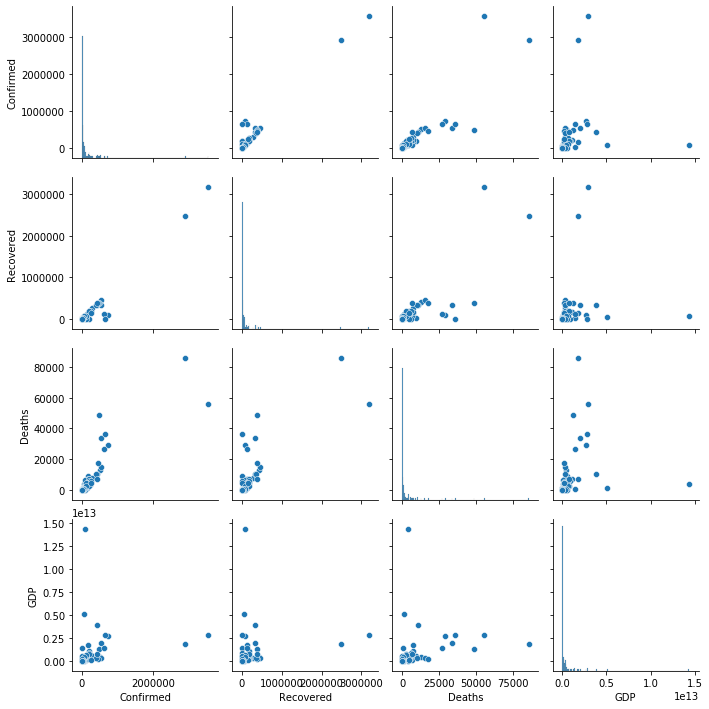

In [7]:
# Exploring if the GDP has a correlation with the deaths, recovered and confirmed cases
dff = pd.read_csv("GDPS.csv",header=2)
dff['GDP'] = dff.ffill(axis=1).iloc[:, -1] 
dff = dff[['Country Name','GDP']]
dff = pd.merge(df.groupby(['Country']).mean(), dff, left_on='Country', right_on='Country Name')#.drop(["Country Name"], axis=1)
sns.pairplot(dff)
plt.show()

If we do not plot the mean for each country, we receive the following:
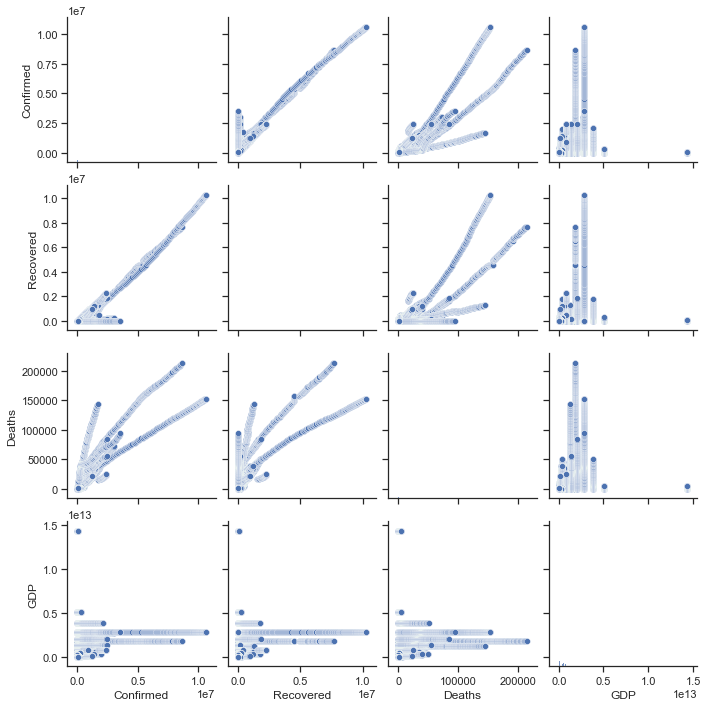

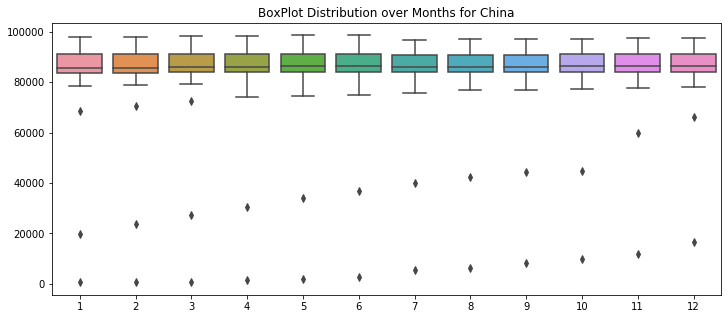

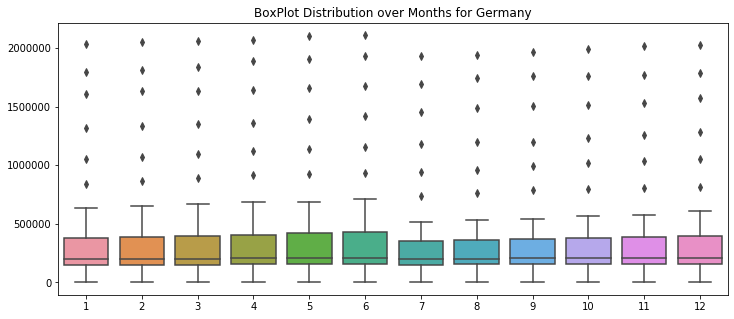

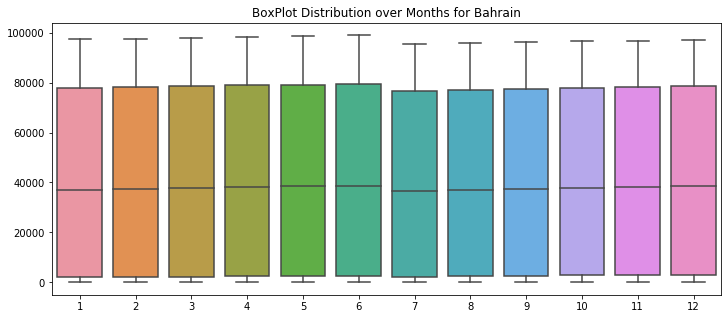

In [8]:
# Plotting BoxPlots for each of our home countries in a timeframe of one year (1 month per boxplot)
for country in ["China","Germany","Bahrain"]:
    ts = pd.Series(df[df["Country"]==country].Confirmed.to_numpy(), index=pd.date_range(start=df[df["Country"]==country].Date.iloc[0], periods=len(df[df["Country"]==country]), freq="M"))
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title("BoxPlot Distribution over Months for "+country)
    seaborn.boxplot(ts.index.month, ts, ax=ax)
    plt.show()

### Exploring if the location of a country is significant

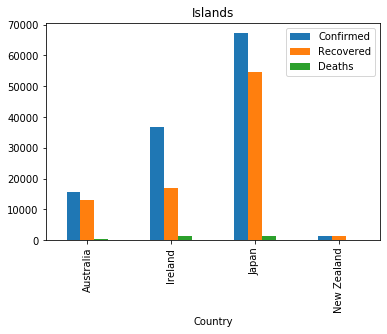

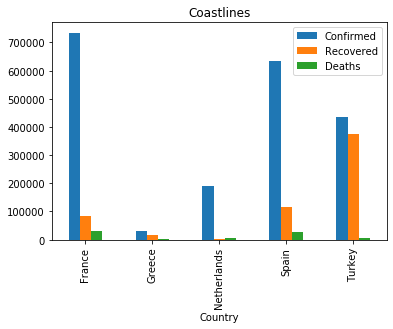

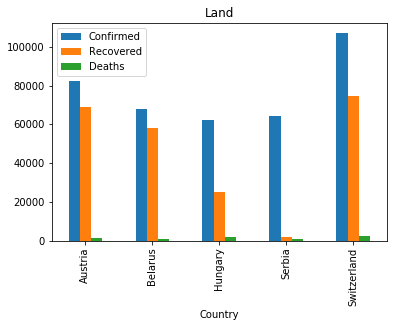

In [9]:
# Islands
df[df.Country.isin(["Japan","Australia","New Zealand","Great Britain","Island","Ireland"])].groupby("Country").mean().plot.bar(title="Islands")

# Coutnries with a coastline
df[df.Country.isin(["France","Netherlands"," Zealand","Greece","Turkey","Spain"])].groupby("Country").mean().plot.bar(title="Coastlines")

# Countries with many neighboars
df[df.Country.isin(["Austria","Czech Republic","Hungary","Serbia","Switzerland","Belarus"])].groupby("Country").mean().plot.bar(title="Land")

plt.show()

## Data Preparation and Data Modeling

In [10]:
"""
This class is used for throwing an exception if the user tried to access a
country which is not present in the dataset
"""
class NoSuchCountry(Exception):
    """No such country could be found in the dataset error"""
    def __init__(self, message):
        self.message = message

In [11]:
"""
This method formats given input parameters into a dictionary shape 

Params: 
    yhat    DataFrame : Containing the date values and the precomputed predictions
    country    String : The name of the country for which we compute the week
    ytest   DataFrame : Containing the actual values we test against
    
Return:
    JSON_Obj     Dict : An object containing all parameters

"""
def create_JSON(yhat, country, ytest):
    JSON_Obj = {
        "Country" : country,
        "Prediction" :
        dict([(str(e1), int(e2)) for e1, e2 in zip(yhat.index.tolist(),yhat.values.tolist())]),
        "Actual_Values" : dict([(str(e1), int(e2)) for e1, e2 in zip(yhat.index.tolist(),ytest.values.tolist())])
    }
    return JSON_Obj

In [12]:
"""
This method inserts/updates prediction values into a MongoDB collection 

Params: 
    DataObject   Dict : Containing the data to be inserted into the database
    
Return:
    True      Boolean : As an indicator that the process has finsihed

"""
#database tables should contain the following information: country, date, predicted value of confirmed diseases
def insertIntoDB(DataObject):
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["Project_TeamA"]
    coronaData = db["CoronaData"]
    collections = db.list_collection_names()
    if "CoronaData" in collections:
        dataFound = coronaData.find({},{ "Country": DataObject.get("Country") })
        # If no data is present with the same country name then we insert it
        if dataFound.count()==0:
            inserted_data_file = coronaData.insert_one(DataObject)
            print("Data was inserted into the database")
        # Else we will update it to include the new values    
        else:
            coronaData.delete_one({"Country": DataObject.get("Country")})
            inserted_data_file = coronaData.insert_one(DataObject)
            print("Data was updated in the database")
    # If the collection has not yet been created we will create it here by performing an insert        
    else:
        inserted_data_file = coronaData.insert_one(DataObject)
        print("Data was inserted into the database")
    print()
    client.close()
    return True

In [13]:
"""
This method performs a prediction for a country given on the dataset of covid data 

Params: 
    country    String : The name of the country for which we compute the week
    
Return:
    JSON_Obj     Dict : An object containing all the data that has to be inserted into the database

"""
def check_country(country):
    
    # If the user passes a country that is not in the dataset we will raise an exception
    if(country not in set(df["Country"])):
        raise NoSuchCountry("Sorry the country was not found in the dataset.")
    
    # Else we filter the data to include only the data of the passed country
    data = df[df["Country"]==country]

    # The data is being split into a training and testing set, where the test contains the last 7 days 
    data_train = data[:len(data)-7]
    data_test = data[-7:]     
    
    # We are dropping the Date column after changing the index to consist of the data values
    data_train.index = pd.to_datetime(data_train["Date"])
    data_train = data_train.drop("Date",axis=1)
    data_test.index = pd.to_datetime(data_test["Date"])
    data_test = data_test.drop("Date",axis=1)
    
    # Here we are fitting the model based on the "Confirmed" feature
    # You can switch the model by commenting it in, to see how it is performing
    # model = SARIMAX(data_train["Confirmed"], order=(1,1,1))
    model = ARIMA(data_train["Confirmed"], order=(1,1,1))
    # model = AutoReg(data_train["Confirmed"], lags=1)
    model_fit = model.fit()

    # Here we are predicting 7 days on the inital training data
    yhat = model_fit.predict(len(data_train),len(data_train)+6)
    
    # And then we print out different error scores
    print(country,"R2:\t", r2_score(data_test["Confirmed"].values,yhat.values.astype(int)))
    print(country,"MSE:\t", mean_squared_error(data_test["Confirmed"].values,yhat.values.astype(int)))
    print(country,"MAPE:\t", mean_absolute_percentage_error(data_test["Confirmed"].values,yhat.values.astype(int)))
 
    # Building a Random Forest to predict Deaths and Recovered cases based on the column confirmed    
    predict_test = predict_random_forest(data, data_test)
    
    ######################### DATA VISUALIZATION #########################
    plot_graphs(data_train, data_test, yhat, predict_test, country)

    return create_JSON(yhat, country, data_test["Confirmed"])
    

In [14]:
"""
This method performs a prediction for a country given on the dataset of covid data for the recovered & death cases

Params: 
    data           DataFrame : The training data for the random forest
    data_test      DataFrame : The test data for the random forest
    
Return:
    predict_test   DataFrame : Containing all the data that was predicted for the test_data

"""
def predict_random_forest(data, data_test): 
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(data["Confirmed"].to_numpy().reshape(-1, 1), data[["Recovered","Deaths"]]);
    predictions = rf.predict(data_test["Confirmed"].to_numpy().reshape(-1, 1))
    predict_test = pd.DataFrame(predictions)
    predict_test = predict_test.rename({0:"Recovered",1:"Deaths"},axis=1)
    predict_test.index = data_test.index
    predict_test.Recovered = predict_test.Recovered.astype("int")
    predict_test.Deaths = predict_test.Deaths.astype("int")
    
    print("\nPredicted Recovered Cases & Deaths:\n",predict_test,"\n")
    return predict_test

In [15]:
"""
This methodbuilds visualizations on our dataset and it's predictions

Params: 
    data_train     DataFrame : The training data
    data_test      DataFrame : The test data
    yhat           DataFrame : The predictions for test data given by a regression model
    predict_test   DataFrame : The predictions for deaths and recovered given by a random forest
    
Return:
    void (Graphs)

"""
def plot_graphs(data_train, data_test, yhat, predict_test, country):
    
    # Creating a plot for Actual vs. Predicted Confirmed 
    plt.figure(figsize=(15,7))
    plt.title(country+"_TEST")
    data_test["Confirmed"].plot(x='datetime', label=(country.upper()+"_ACTUAL"))
    yhat.plot(x='datetime', label=(country.upper()+"_PREDICTED"))
    plt.legend()
    plt.show()
    
    # Creating a plot for Train Data 
    plt.figure(figsize=(15,7))
    plt.title(country+"_TRAIN")
    data_train["Confirmed"].plot(x='datetime', label=country.upper()+"_TRAIN")
    plt.legend()
    plt.show()
    
    # Creating a plot for Recovered Actual vs. Recovered Confirmed 
    plt.figure(figsize=(15,7))
    plt.title(country+"_RECOVERED_&_DEATHS")
    data_test["Recovered"].plot(x='datetime', label=(country.upper()+"_ACTUAL_RECOVERED"))
    predict_test.Recovered.plot(x='datetime', label=(country.upper()+"_PREDICTED_RECOVERED"))
    plt.legend()
    plt.show()
    
    # Creating a plot for Deaths Actual vs. Deaths Predicted 
    plt.figure(figsize=(15,7))
    data_test["Deaths"].plot(x='datetime', label=(country.upper()+"_ACTUAL_DEATHS"))
    predict_test.Deaths.plot(x='datetime', label=(country.upper()+"_PREDICTED_DEATHS"))
    plt.legend()
    plt.show()

In [16]:
"""
This method is a wrapper for the check_country method that takes in a list of countries

Params: 
    country_list    List of String : A list containing multiple countries
    
Return:
    void

"""
def predictForCountry(country_list):
    for country in country_list:
        print("Checking",country,"\n")
        insertIntoDB(check_country(country))
        print("---------------------------------------")

## Data Presentation and Automation

### Predicting for Own Countries

Checking China 

China R2:	 0.47029902031168114
China MSE:	 61134.71428571428
China MAPE:	 0.002157524155543162

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15      91105    4796
2021-01-16      91137    4796
2021-01-17      91191    4797
2021-01-18      91276    4798
2021-01-19      91315    4799
2021-01-20      91373    4800
2021-01-21      91373    4800 



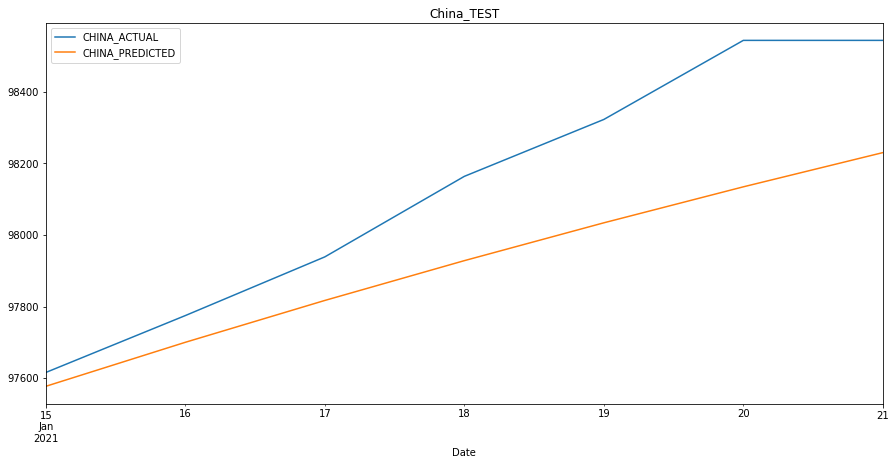

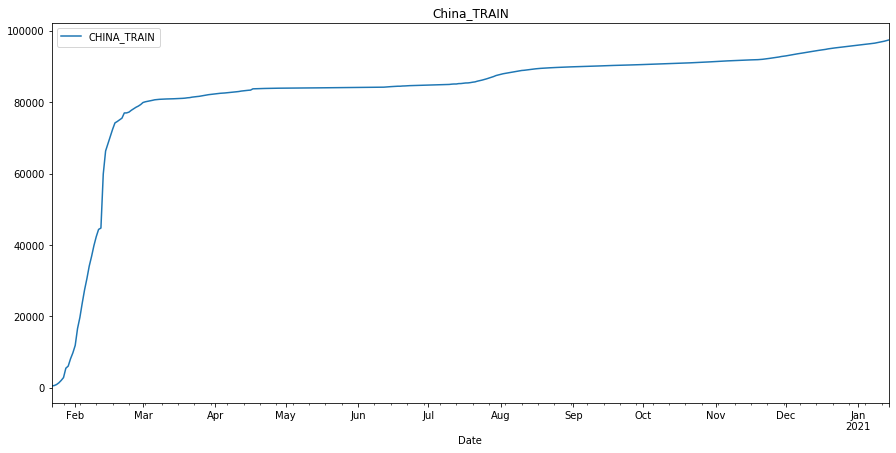

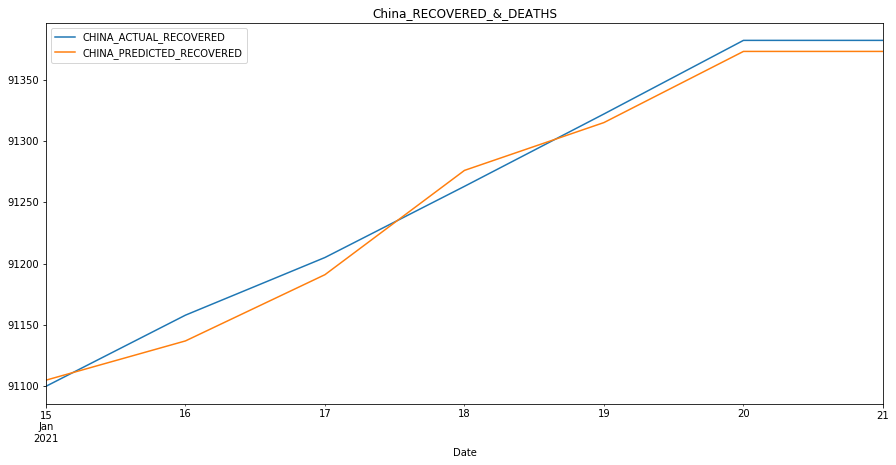

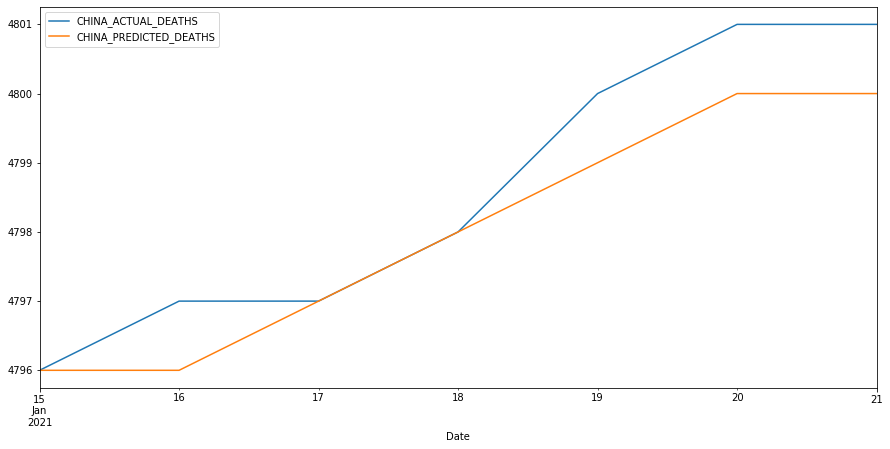

Data was inserted into the database

---------------------------------------
Checking Germany 

Germany R2:	 -0.3838892362900366
Germany MSE:	 1162682475.0
Germany MAPE:	 0.01523582111763358

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15    1665266   45614
2021-01-16    1689945   46597
2021-01-17    1706558   46937
2021-01-18    1717383   47413
2021-01-19    1746059   48544
2021-01-20    1780003   50089
2021-01-21    1787734   50435 



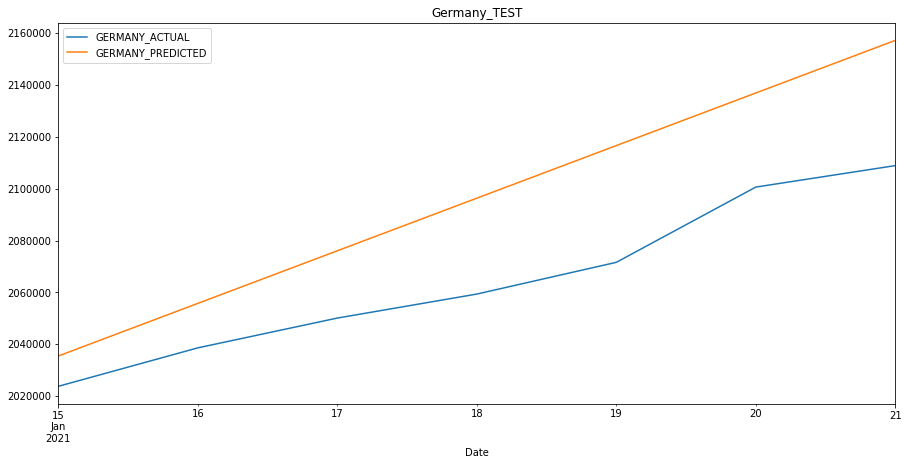

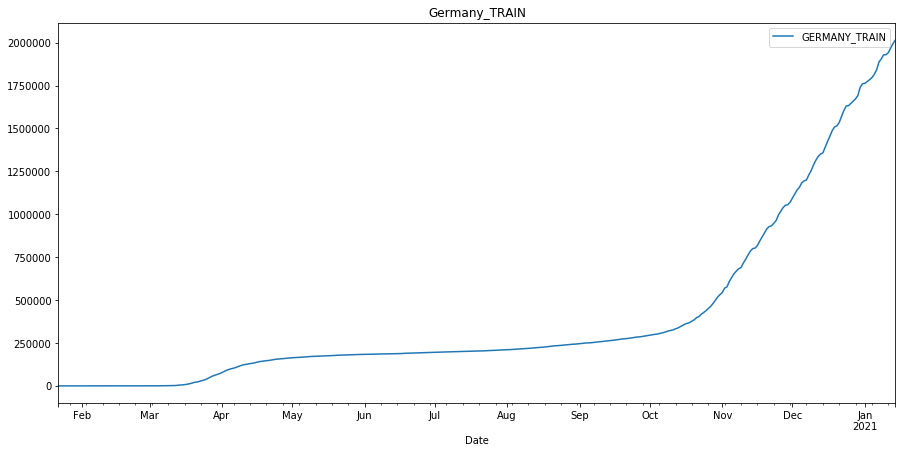

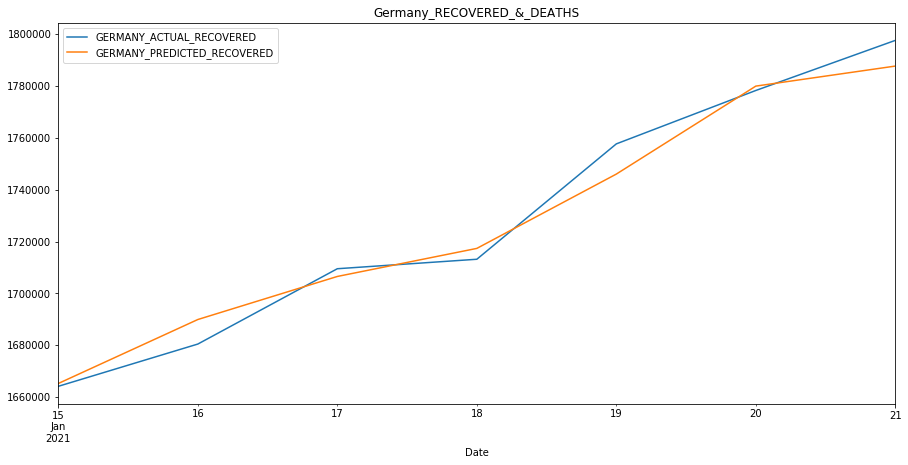

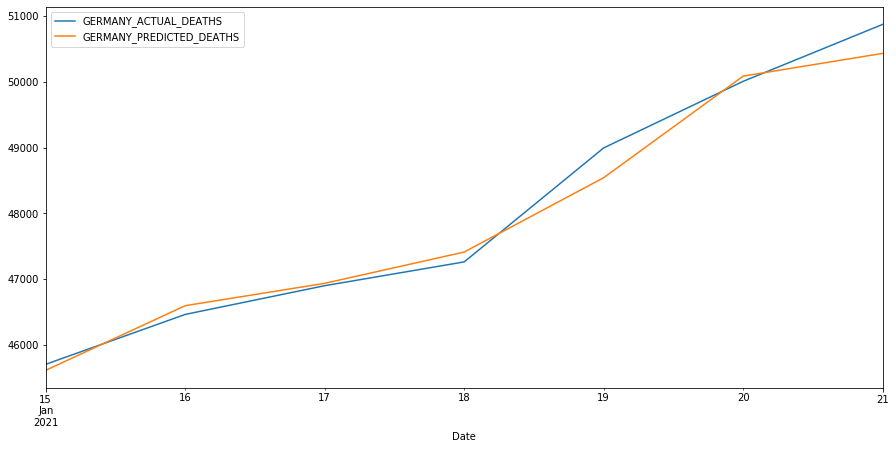

Data was updated in the database

---------------------------------------
Checking Bahrain 

Bahrain R2:	 0.9698446167297615
Bahrain MSE:	 12026.142857142857
Bahrain MAPE:	 0.0010823084357885024

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15      93628     356
2021-01-16      93934     357
2021-01-17      94318     359
2021-01-18      94696     360
2021-01-19      94983     362
2021-01-20      95285     365
2021-01-21      95427     365 



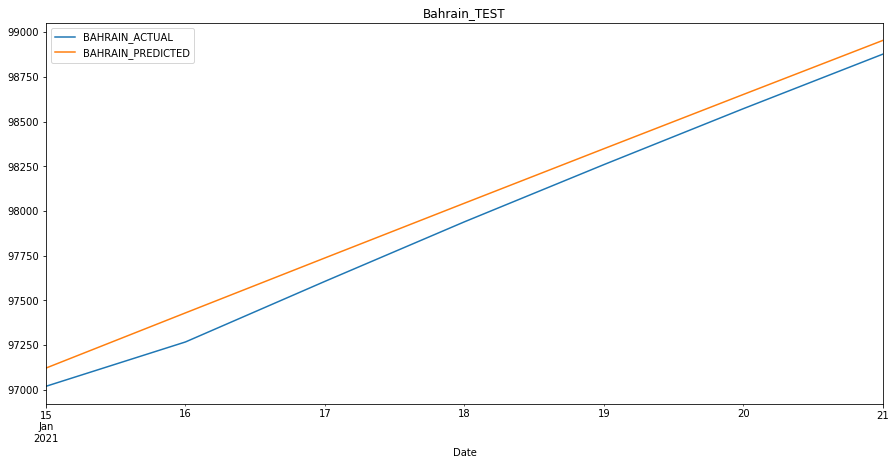

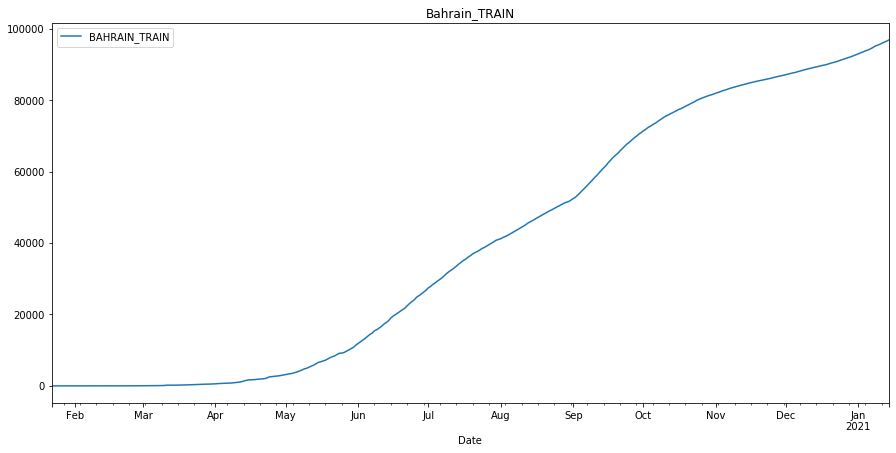

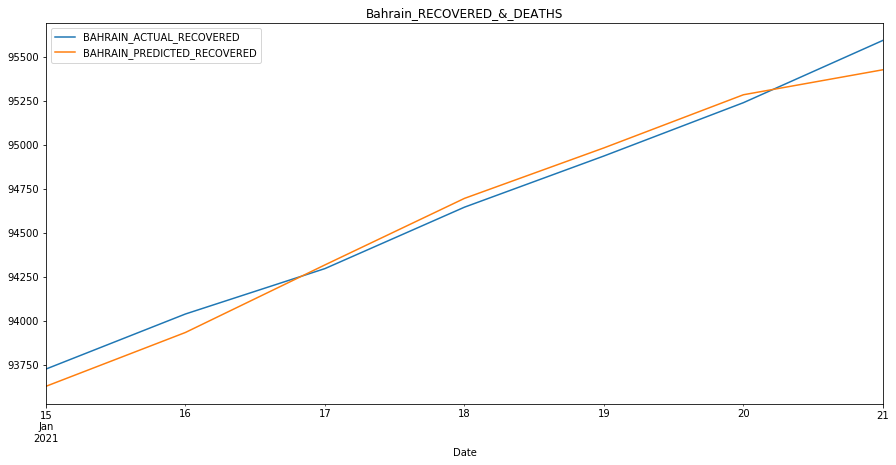

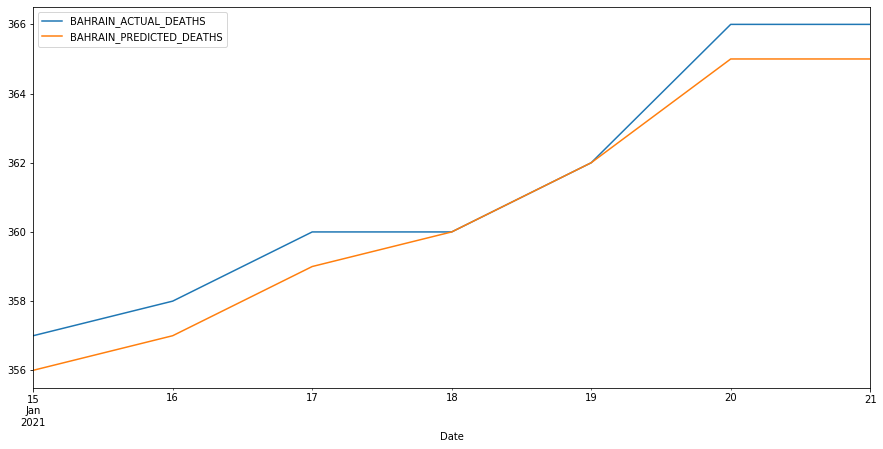

Data was updated in the database

---------------------------------------


In [17]:
# Predicting our home countries
predictForCountry(["China","Germany","Bahrain"])

### Predicting for Other Countries

Checking Russia 

Russia R2:	 0.982280100903488
Russia MSE:	 34690330.85714286
Russia MAPE:	 0.0011880010671921747

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15    2882667   63640
2021-01-16    2912596   64271
2021-01-17    2932109   64689
2021-01-18    2952364   65181
2021-01-19    2974545   65725
2021-01-20    2988931   66063
2021-01-21    3009341   66525 



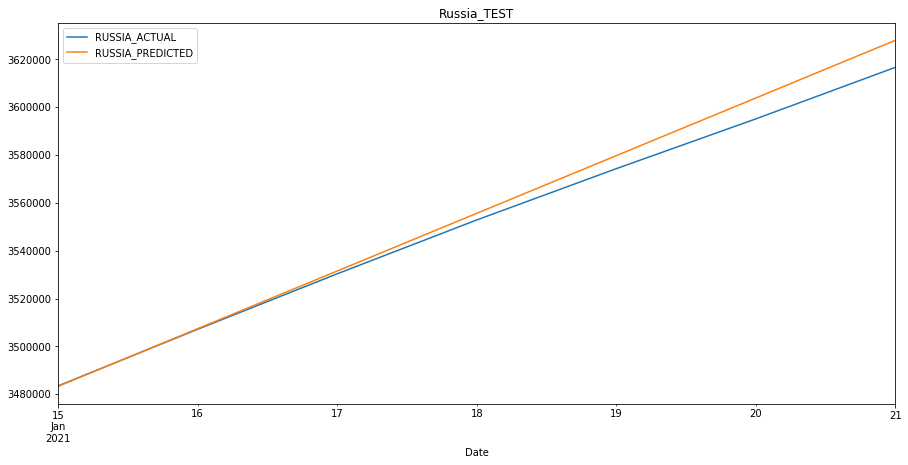

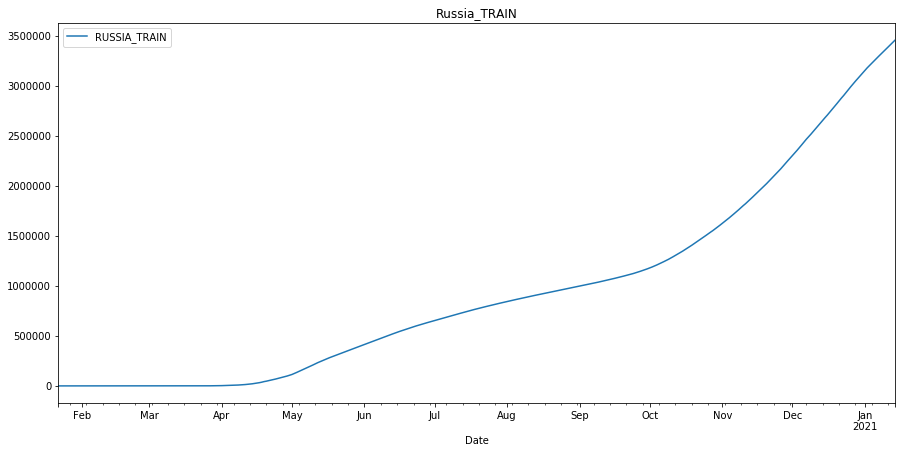

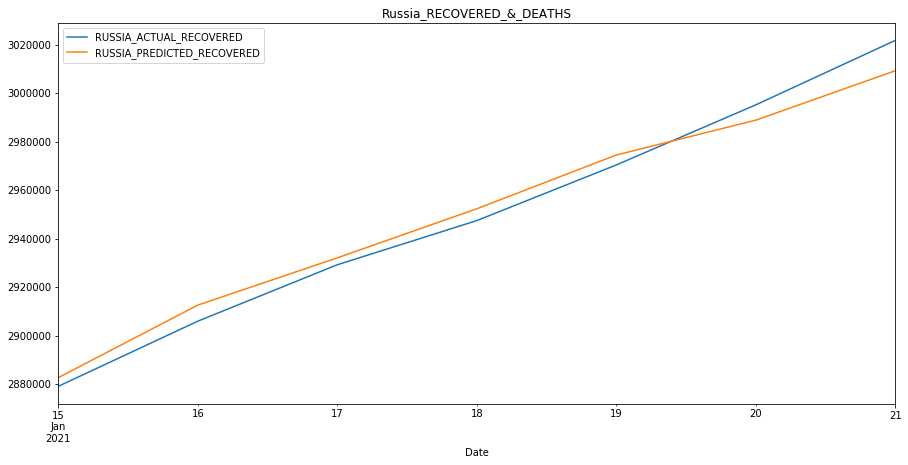

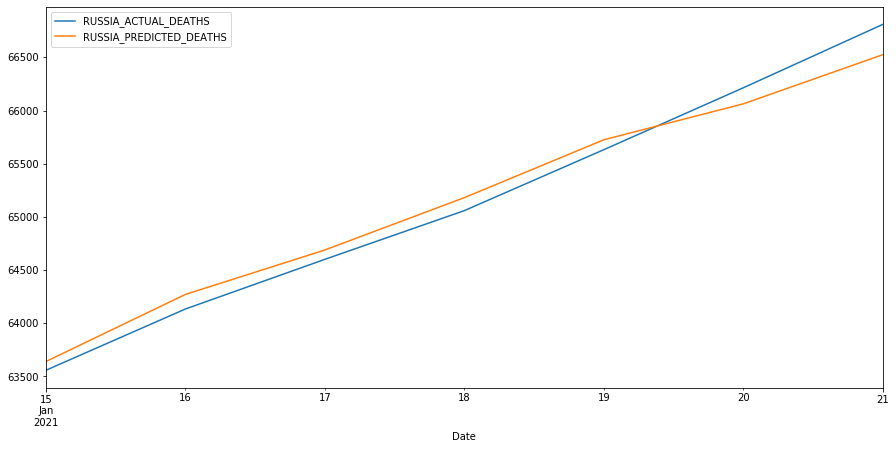

Data was updated in the database

---------------------------------------
Checking France 

France R2:	 0.9599216590312821
France MSE:	 65494329.85714286
France MAPE:	 0.0024025743869656663

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15     213847   70012
2021-01-16     213847   70013
2021-01-17     215764   70644
2021-01-18     216126   70814
2021-01-19     217523   71355
2021-01-20     219491   71825
2021-01-21     220009   71964 



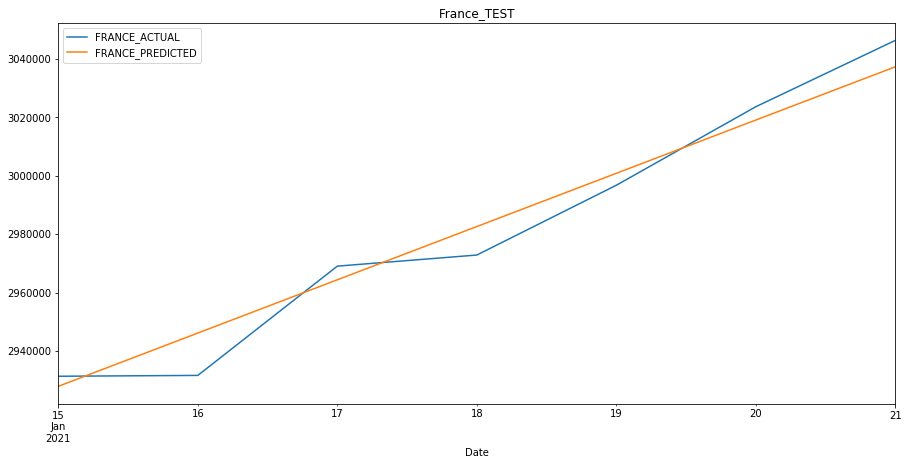

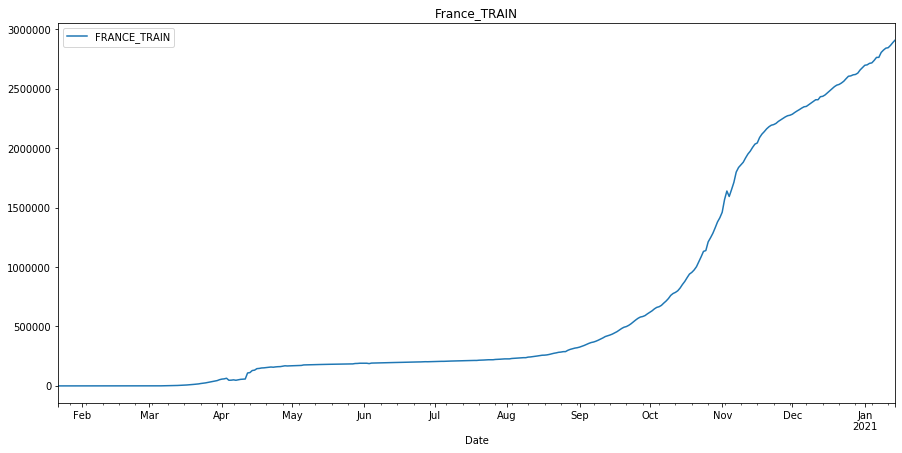

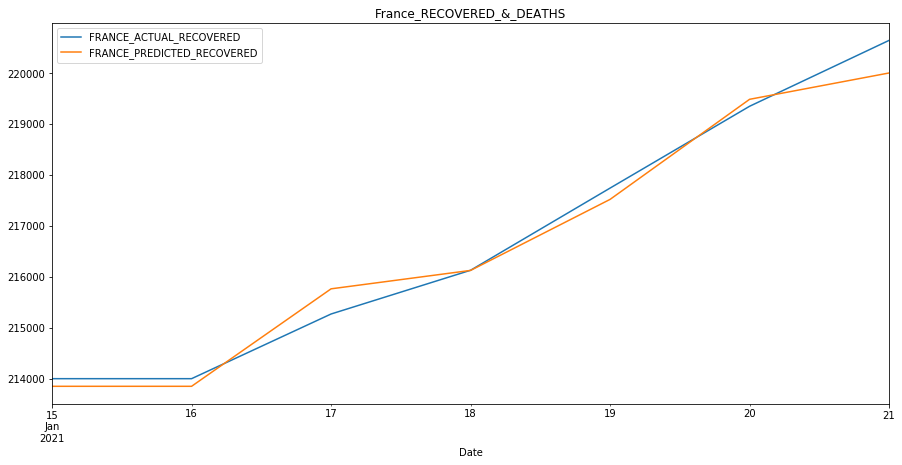

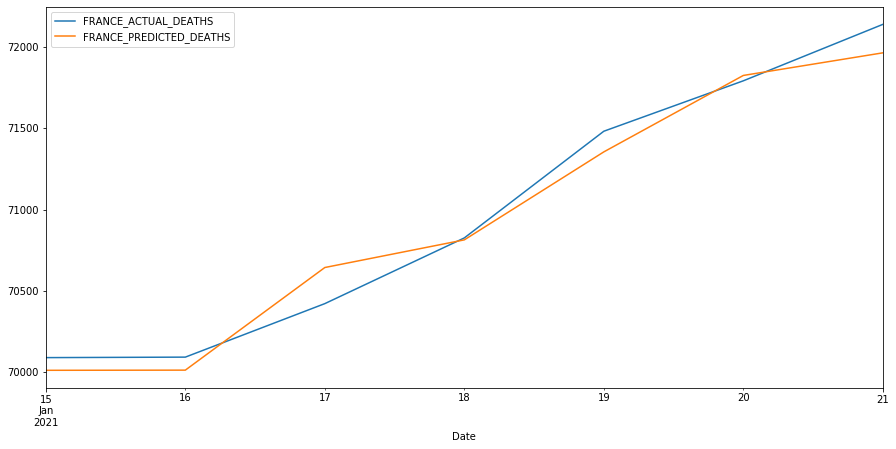

Data was updated in the database

---------------------------------------
Checking Japan 

Japan R2:	 0.9404788152310078
Japan MSE:	 7422967.714285715
Japan MAPE:	 0.006153321375311592

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15     239161    4207
2021-01-16     245139    4279
2021-01-17     249154    4331
2021-01-18     252197    4395
2021-01-19     257020    4620
2021-01-20     263138    4747
2021-01-21     269357    4821 



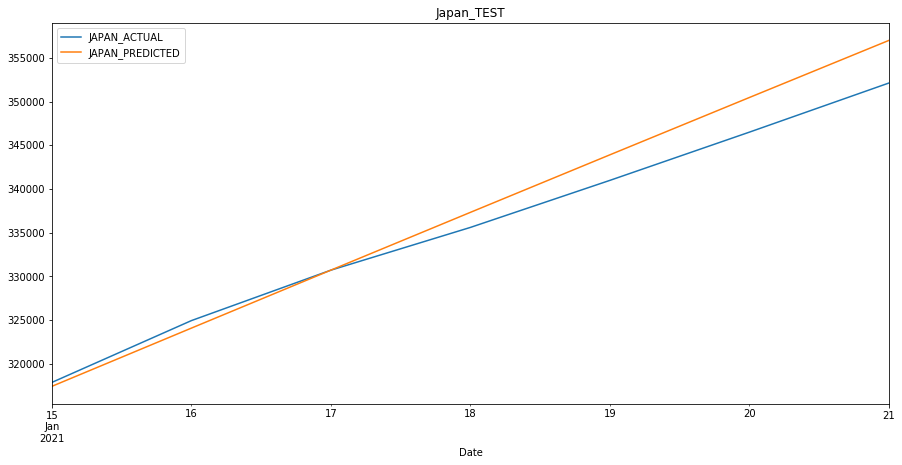

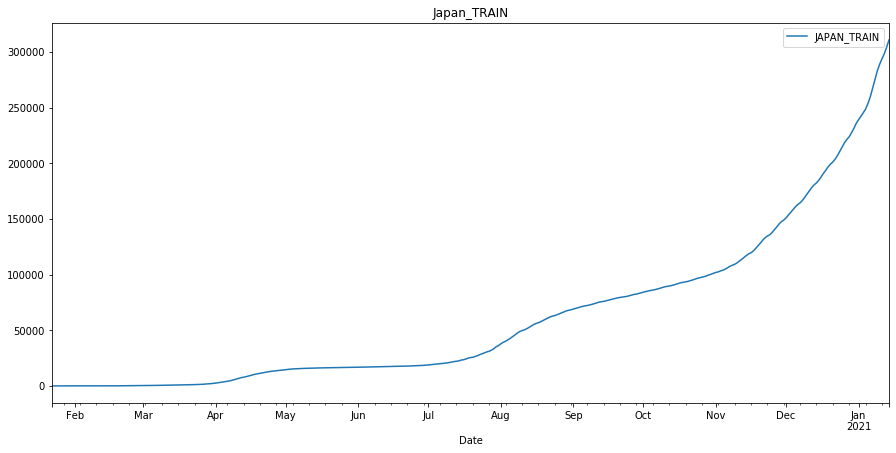

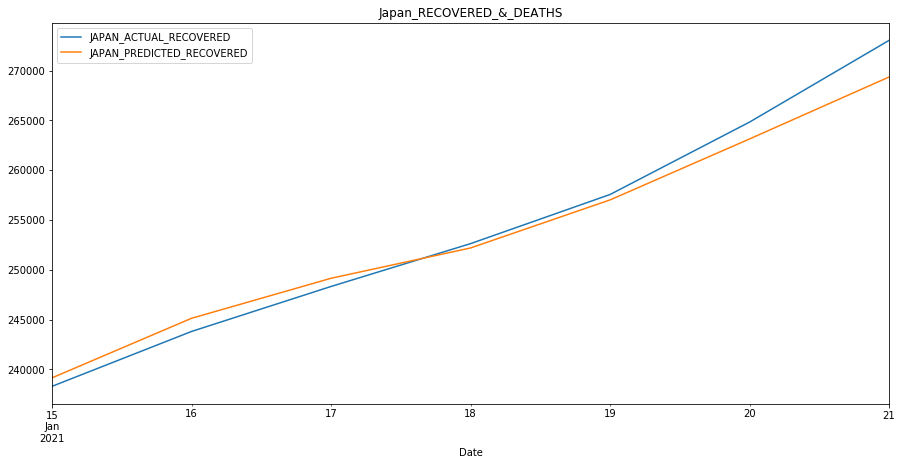

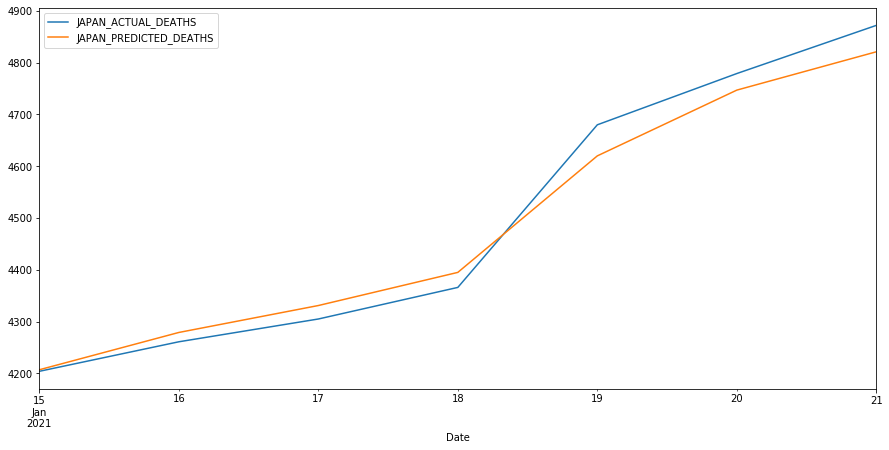

Data was updated in the database

---------------------------------------
Checking Spain 

Spain R2:	 0.6074338280777596
Spain MSE:	 2390514496.142857
Spain MAPE:	 0.017176505524094547

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15     150376   53293
2021-01-16     150376   53293
2021-01-17     150376   53293
2021-01-18     150376   53908
2021-01-19     150376   54150
2021-01-20     150376   54518
2021-01-21     150376   54845 



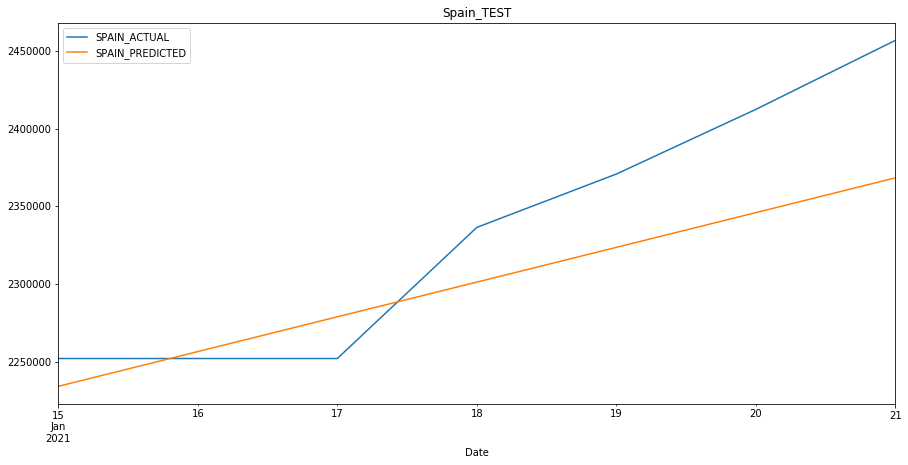

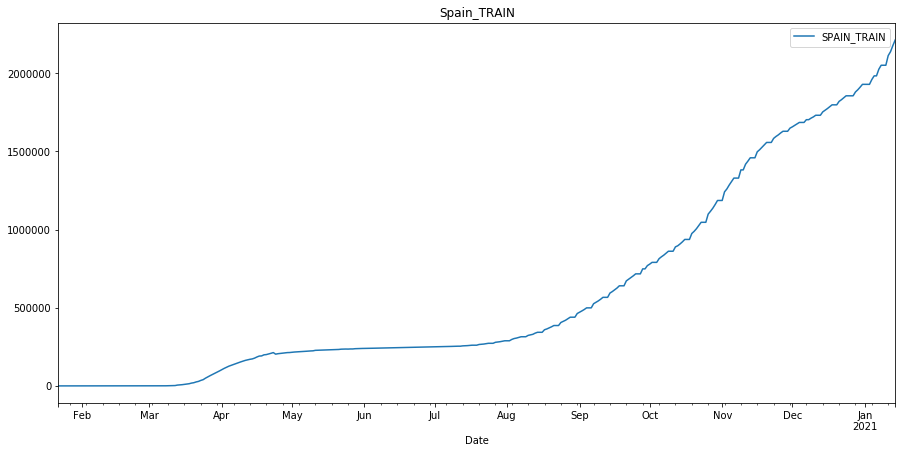

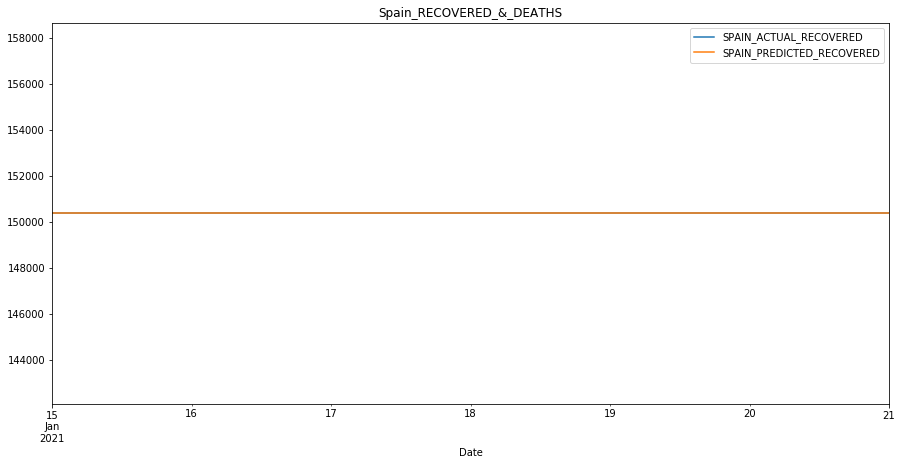

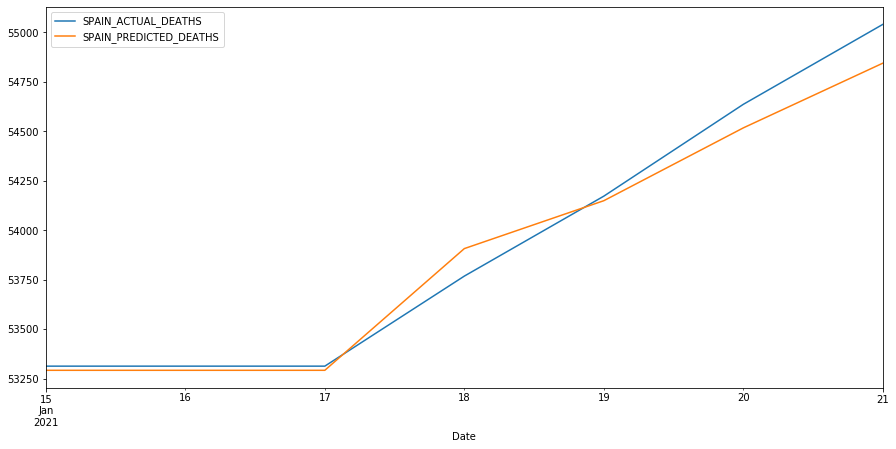

Data was updated in the database

---------------------------------------
Checking Italy 

Italy R2:	 0.6069964998290458
Italy MSE:	 229807249.2857143
Italy MAPE:	 0.00512216585246647

Predicted Recovered Cases & Deaths:
             Recovered  Deaths
Date                         
2021-01-15    1708886   81225
2021-01-16    1734318   81912
2021-01-17    1748662   82258
2021-01-18    1759606   82538
2021-01-19    1779058   83060
2021-01-20    1800451   83543
2021-01-21    1817310   83950 



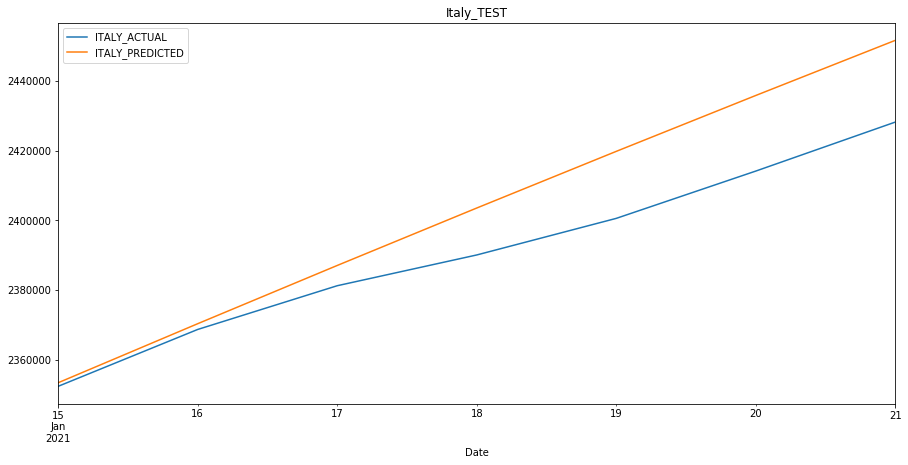

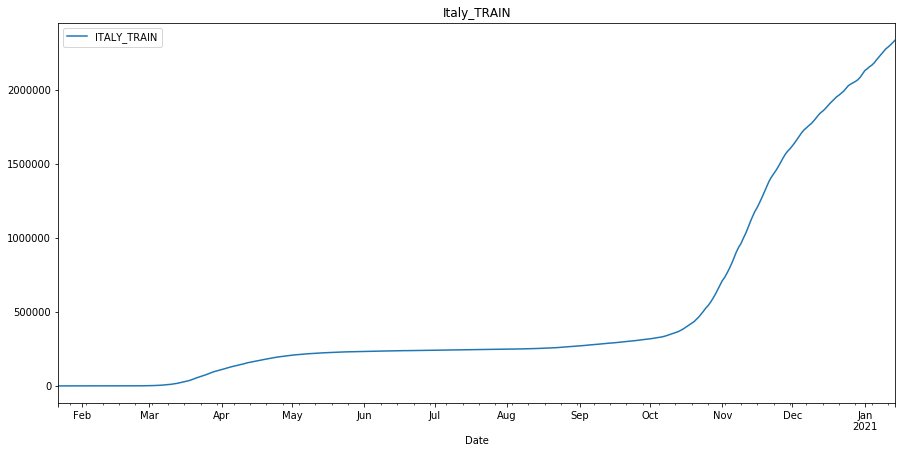

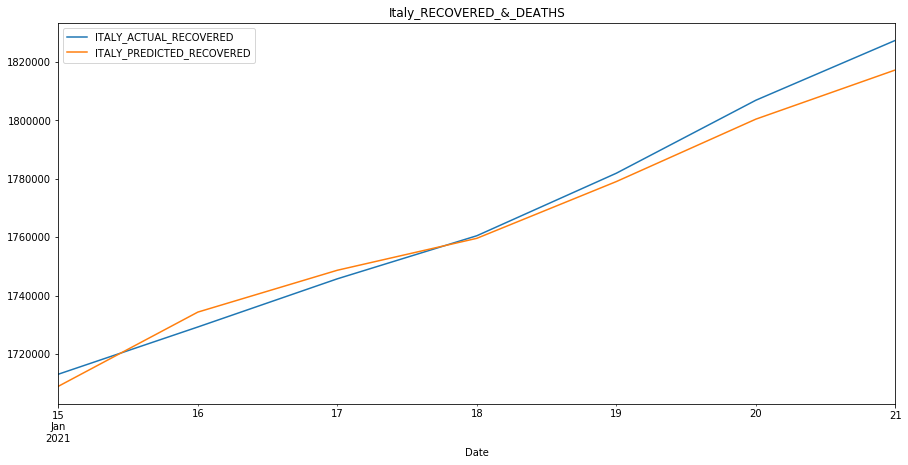

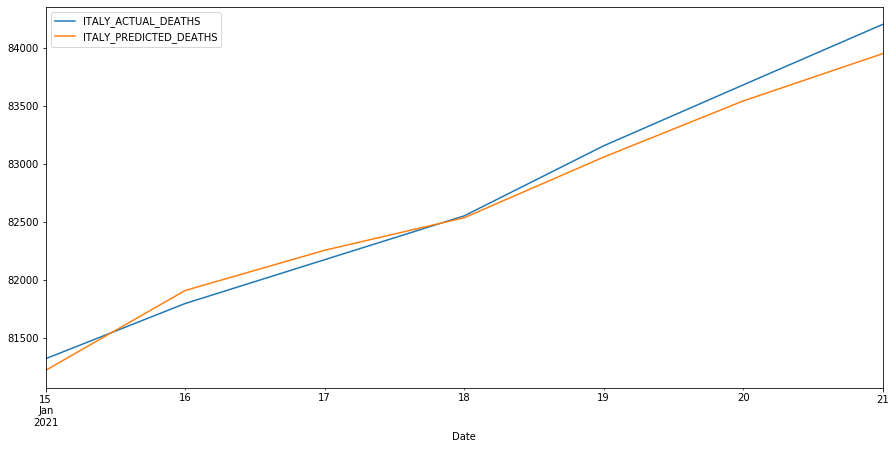

Data was updated in the database

---------------------------------------


In [18]:
# Predicting other countries that might be of interest
predictForCountry(["Russia","France","Japan","Spain","Italy"])

## Inserting values into database

### Database Schema:

{
   "Country": String,
   "Prediction": {
      String: number,
   },
   "Actual_Values": {
   String: number
   }
}

* **Country** corresponds to the country name
* **Prediction** is an object containing the values of a date (as String) and it's corresponding prediction value
* **Actual_Values** is an object containing the values of a date (as String) and it's corresponding value from y_test

In [19]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Project_TeamA"]
coronaData = db["CoronaData"]
    
query = coronaData.find()

for result in query:
    print(result)
    
# Printing all collections in the db
#print(db.list_collection_names())
    
# Delete one entry
#coronaData.delete_one({"Country":"China"})

# Delete all entries
#coronaData.delete_many({})

{'_id': ObjectId('6013e85bf66896ee03aca0d9'), 'Country': 'China', 'Prediction': {'2021-01-15 00:00:00': 97577, '2021-01-16 00:00:00': 97700, '2021-01-17 00:00:00': 97817, '2021-01-18 00:00:00': 97928, '2021-01-19 00:00:00': 98034, '2021-01-20 00:00:00': 98134, '2021-01-21 00:00:00': 98230}, 'Actual_Values': {'2021-01-15 00:00:00': 97616, '2021-01-16 00:00:00': 97775, '2021-01-17 00:00:00': 97939, '2021-01-18 00:00:00': 98164, '2021-01-19 00:00:00': 98323, '2021-01-20 00:00:00': 98544, '2021-01-21 00:00:00': 98544}}
{'_id': ObjectId('6013e85df66896ee03aca0db'), 'Country': 'Germany', 'Prediction': {'2021-01-15 00:00:00': 2035510, '2021-01-16 00:00:00': 2055786, '2021-01-17 00:00:00': 2076062, '2021-01-18 00:00:00': 2096337, '2021-01-19 00:00:00': 2116613, '2021-01-20 00:00:00': 2136889, '2021-01-21 00:00:00': 2157164}, 'Actual_Values': {'2021-01-15 00:00:00': 2023828, '2021-01-16 00:00:00': 2038645, '2021-01-17 00:00:00': 2050129, '2021-01-18 00:00:00': 2059382, '2021-01-19 00:00:00': 20